<a href="https://colab.research.google.com/github/google/ground-platform/blob/master/notebooks/generate_offline_imagery2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Post-process Ground imagery (2/2)

This notebook converts normal GeoTIFFs into cloud optimized-GeoTIFFs (COGs) compatible with Google Maps Platform APIs and the Ground data collection platform Android app.

We've affectionally dubbed these Maps-optimized COGs as "MOGs" for convenience and brevity. See [README.md](https://github.com/google/ground-android/blob/master/ground/src/main/java/com/google/android/ground/ui/map/gms/mog/README.md) in Android implementation for details.

Be sure [Generate Ground offline imagery](https://colab.research.google.com/github/google/ground-platform/blob/master/notebooks/generate_offline_imagery1.ipynb) has been run and Earth Engine tasks have completed before running this notebook.

By default, only new input images will be converted. GeoTIFF which already have a correspondign MOG will be skipped unless `OVERWRITE_EXISTING` is set `True`.

##  Configuration

### Required inputs

In [1]:
BUCKET_NAME=input('ID of bucket where GeoTIFFs are read and written: ')

ID of bucket where GeoTIFFs are read and written: ground-raster-basemaps


### Custom paths

The can be adjusted as needed.

In [2]:
SRC_PATH="2022/geotiff"
DEST_PATH="2022/cog"

### Other constants

Only modify these if you know what you're doing!

In [9]:
from math import pi

HI_RES_MOG_MIN_ZOOM=8
HI_RES_MOG_MAX_ZOOM=14
TILE_SIZE=256
NODATA_VALUE=0
OVERVIEW_FILENAME="overview.tif"
OVERWRITE_EXISTING=False

SRC_PREFIX=f"{SRC_PATH}/{HI_RES_MOG_MIN_ZOOM}"
OVERVIEW_TIFF_PATH=f"{SRC_PREFIX}/{OVERVIEW_FILENAME}"
DEST_PREFIX=f"{DEST_PATH}/{HI_RES_MOG_MIN_ZOOM}"
OVERVIEW_COG_PATH=f"{DEST_PREFIX}/{OVERVIEW_FILENAME}"

# Constants
TMP_FILENAME="temp.tif"
GCS_BROWSER_BASE_URL="https://console.cloud.google.com/storage/browser"
GCS_DETAILS_BASE_URL="https://console.cloud.google.com/storage/browser/_details"
EPSG_3857_MAX = pi * 6378137
EPSG_3857_WORLD_BOUNDS=(-EPSG_3857_MAX, -EPSG_3857_MAX, EPSG_3857_MAX, EPSG_3857_MAX)

## Setup

### Authenticate user

In [4]:
from google.colab import auth

auth.authenticate_user()

### Install deps

In [5]:
!pip install rasterio rio-cogeo gdal

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 50.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 381.9/381.9 kB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 21.0 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.5.0
    Uninstalling typing_extensions-4.5.0:
      Successfully uninstalled typing_extensions-4.5.0
  Attempting uninstall: pydantic
    Found existing installation: pydantic 1.10.13
    Uninstalling pydantic-1.10.13:
      Successfully uninstalled pydantic-1.10.13
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-mult

### Imports and vars

In [12]:
from google.cloud import storage
import rasterio
from rasterio.transform import from_origin
from rasterio.enums import Resampling
from rasterio.windows import from_bounds
from osgeo import gdal # https://gdal.org/api/python/osgeo.gdal.html
import os
from rasterio.plot import show
import matplotlib.pyplot as plt
import numpy as np
import re
import tempfile

storage_client = storage.Client()
bucket = storage_client.bucket(BUCKET_NAME)

## Build MOGs


### Define functions

In [19]:
def show_thumbnail(src_path):
  file_stats=os.stat(overview_tmp_path)
  print(f'{src_path}: {file_stats.st_size / (1024 * 1024):.2f} MB')
  with rasterio.open(src_path) as ds:
    print(f'Profile: {ds.profile}')
    plt.figure(figsize=(4, 4))
    show(ds.read(out_shape=(3, 512, 512)))

def build_cog(src_path, dst_path):
  """Convert image to Maps Optimized GeoTIFF and upload to GCS."""

  gdal.UseExceptions()

  # Open the input raster
  src=gdal.Open(src_path)

  # Open the output raster
  ds=gdal.Translate(
      destName=TMP_FILENAME,
      srcDS=src,
      format="COG",
      options=["GDAL_TIFF_INTERNAL_MASK=YES"],
      creationOptions=[
          f"BLOCKSIZE={TILE_SIZE}",
          "BIGTIFF=NO",
          "TILING_SCHEME=GoogleMapsCompatible",
          "COMPRESS=JPEG",
          "QUALITY=75"
      ]
  )

  # Close the output raster to flush buffer.
  ds = None
  tmp_ds = None

  file_size = os.stat(TMP_FILENAME).st_size / (1024 * 1024)
  print(f"Uploading {file_size:.1f} MB to {dst_path}")
  bucket.blob(dst_path).upload_from_filename(TMP_FILENAME)

### Build hi-res COGs

Scanning https://console.cloud.google.com/storage/browser/ground-raster-basemaps/2022/geotiff/8
Building COGs from 876 GeoTIFFs
['2022/geotiff/8/100/130.tif', '2022/geotiff/8/100/131.tif', '2022/geotiff/8/100/132.tif', '2022/geotiff/8/100/133.tif', '2022/geotiff/8/100/134.tif', '2022/geotiff/8/100/135.tif', '2022/geotiff/8/100/136.tif', '2022/geotiff/8/100/137.tif', '2022/geotiff/8/100/138.tif', '2022/geotiff/8/100/139.tif', '2022/geotiff/8/100/140.tif', '2022/geotiff/8/100/141.tif', '2022/geotiff/8/101/131.tif', '2022/geotiff/8/101/132.tif', '2022/geotiff/8/101/133.tif', '2022/geotiff/8/101/134.tif', '2022/geotiff/8/101/135.tif', '2022/geotiff/8/101/136.tif', '2022/geotiff/8/102/131.tif', '2022/geotiff/8/102/132.tif', '2022/geotiff/8/102/133.tif', '2022/geotiff/8/102/134.tif', '2022/geotiff/8/102/135.tif', '2022/geotiff/8/103/130.tif', '2022/geotiff/8/103/132.tif', '2022/geotiff/8/103/133.tif', '2022/geotiff/8/103/134.tif', '2022/geotiff/8/104/130.tif', '2022/geotiff/8/107/127.tif', '

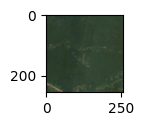

Building 2022/cog/8/142/131.tif
Uploading 30.0 MB to 2022/cog/8/142/131.tif


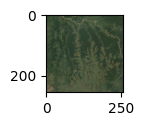

Building 2022/cog/8/142/132.tif
Uploading 28.8 MB to 2022/cog/8/142/132.tif


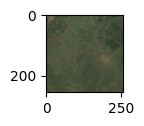

Building 2022/cog/8/142/133.tif
Uploading 22.6 MB to 2022/cog/8/142/133.tif


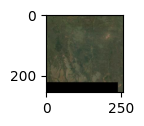

Building 2022/cog/8/143/124.tif
Uploading 14.0 MB to 2022/cog/8/143/124.tif


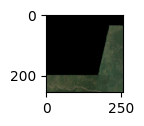

Building 2022/cog/8/143/125.tif
Uploading 27.7 MB to 2022/cog/8/143/125.tif


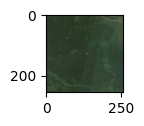

Building 2022/cog/8/143/126.tif
Uploading 27.5 MB to 2022/cog/8/143/126.tif


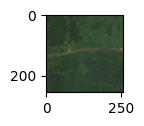

Building 2022/cog/8/143/127.tif
Uploading 22.5 MB to 2022/cog/8/143/127.tif


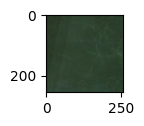

Building 2022/cog/8/143/128.tif
Uploading 24.6 MB to 2022/cog/8/143/128.tif


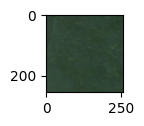

Building 2022/cog/8/143/129.tif
Uploading 24.4 MB to 2022/cog/8/143/129.tif


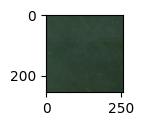

Building 2022/cog/8/143/130.tif
Uploading 26.6 MB to 2022/cog/8/143/130.tif


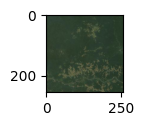

Building 2022/cog/8/143/131.tif
Uploading 32.5 MB to 2022/cog/8/143/131.tif


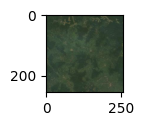

Building 2022/cog/8/143/132.tif
Uploading 36.1 MB to 2022/cog/8/143/132.tif


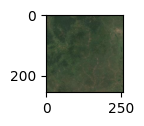

Building 2022/cog/8/143/133.tif
Uploading 30.7 MB to 2022/cog/8/143/133.tif


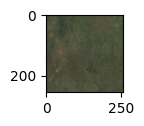

Building 2022/cog/8/143/134.tif
Uploading 26.8 MB to 2022/cog/8/143/134.tif


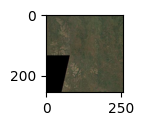

Building 2022/cog/8/143/135.tif
Uploading 18.3 MB to 2022/cog/8/143/135.tif


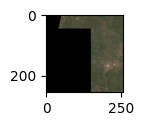

Building 2022/cog/8/143/136.tif
Uploading 8.9 MB to 2022/cog/8/143/136.tif


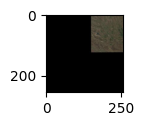

Building 2022/cog/8/144/124.tif
Uploading 26.7 MB to 2022/cog/8/144/124.tif


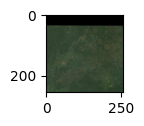

Building 2022/cog/8/144/125.tif
Uploading 27.9 MB to 2022/cog/8/144/125.tif


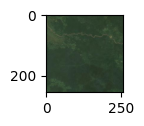

Building 2022/cog/8/144/126.tif
Uploading 27.4 MB to 2022/cog/8/144/126.tif


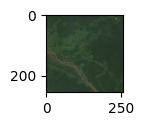

Building 2022/cog/8/144/127.tif
Uploading 25.9 MB to 2022/cog/8/144/127.tif


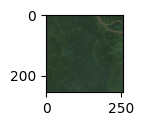

Building 2022/cog/8/144/128.tif
Uploading 25.5 MB to 2022/cog/8/144/128.tif


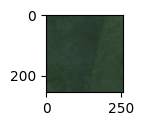

Building 2022/cog/8/144/129.tif
Uploading 24.2 MB to 2022/cog/8/144/129.tif


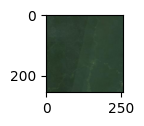

Building 2022/cog/8/144/130.tif
Uploading 29.1 MB to 2022/cog/8/144/130.tif


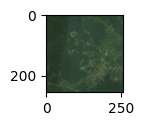

Building 2022/cog/8/144/131.tif


In [ ]:
print(f"Scanning {GCS_BROWSER_BASE_URL}/{BUCKET_NAME}/{SRC_PREFIX}")
src_blobs = storage_client.list_blobs(BUCKET_NAME, prefix=SRC_PREFIX)
src_paths = [b.name for b in src_blobs if b.name.endswith(".tif")]

print(f"Building COGs from {len(src_paths)} GeoTIFFs")
print(src_paths)
print(f"Output: https://console.cloud.google.com/storage/browser/{BUCKET_NAME}/{DEST_PREFIX}")

for subpath in src_paths:
  src_path=f"/vsigs_streaming/{BUCKET_NAME}/{subpath}"
  dst_path=DEST_PREFIX + subpath[len(SRC_PREFIX):]
  blob = storage.Blob(dst_path, bucket)
  if (not OVERWRITE_EXISTING and blob.exists(storage_client)):
    print(f"{dst_path} exists, skipping.")
  else:
    print(f"Building {dst_path}")
    build_cog(
        src_path=src_path,
        dst_path=dst_path
    )
    show_thumbnail(f"/vsigs_streaming/{BUCKET_NAME}/{dst_path}")

print("Done!")

### Rebuild lo-res overview

The overview COG includes a lo-res copy of all COGs in the destination bucket, with missing pixels set to NODATA.

Processing image 0 of 927
Processing image 1 of 927
Processing image 2 of 927
Processing image 3 of 927
Processing image 4 of 927
Processing image 5 of 927
Processing image 6 of 927
Processing image 7 of 927
Processing image 8 of 927
Processing image 9 of 927
Processing image 10 of 927
Processing image 11 of 927
Processing image 12 of 927
Processing image 13 of 927
Processing image 14 of 927
Processing image 15 of 927
Processing image 16 of 927
Processing image 17 of 927
Processing image 18 of 927
Processing image 19 of 927
Processing image 20 of 927
Processing image 21 of 927
Processing image 22 of 927
Processing image 23 of 927
Processing image 24 of 927
Processing image 25 of 927
Processing image 26 of 927
Processing image 27 of 927
Processing image 28 of 927
Processing image 29 of 927
Processing image 30 of 927
Processing image 31 of 927
Processing image 32 of 927
Processing image 33 of 927
Processing image 34 of 927
Processing image 35 of 927
Processing image 36 of 927
Processing 

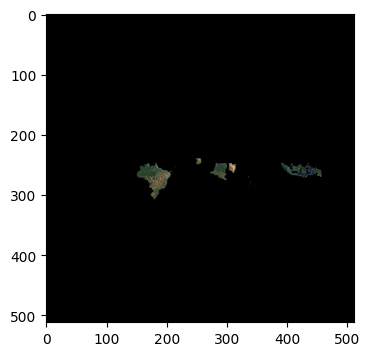

Uploading 13.1 MB to 2022/cog/8/overview.tif


TypeError: ignored

In [15]:
def downscale_profile(profile, factor):
  transform = profile['transform']
  new_profile = profile.copy()
  new_transform = transform * transform.scale(
    (profile['width'] / factor),
    (profile['height'] / factor)
  )
  new_profile.update(transform=new_transform)
  return new_profile

def extend_profile_bounds(profile, xmin, ymin, xmax, ymax):
  transform = profile['transform']
  pixel_size_x, pixel_size_y = transform.a, -transform.e
  new_transform = from_origin(xmin, ymax, pixel_size_x, pixel_size_y)

  new_width = int((xmax - xmin) / pixel_size_x)
  new_height = int((ymax - ymin) / pixel_size_y)

  new_profile = profile.copy()
  new_profile.update(
      width=new_width,
      height=new_height,
      transform=new_transform,
      tiled=True,
      blockxsize=TILE_SIZE,
      blockysize=TILE_SIZE,
      nodata=NODATA_VALUE
    )
  return new_profile

def build_overview_profile(src_path, xmin, ymin, xmax, ymax):
  with rasterio.open(src_path) as src:
    # Downscale one zoom level past smallest overview.
    downscale_factor = src.overviews(1)[-1] * 2
    downscaled_profile = downscale_profile(src.profile, downscale_factor)
    return extend_profile_bounds(downscaled_profile, xmin, ymin, xmax, ymax), downscale_factor

def write_canvas(dst, profile):
  count = profile['count']
  width = profile['width']
  height = profile['height']
  shape = (count, height, width)
  dtype = profile['dtype']
  dst.write(np.full(shape, NODATA_VALUE, dtype))

def calculate_offsets(src, dst_profile, xmin, ymax):
  pixel_size_x, pixel_size_y = dst_profile['transform'].a, -dst_profile['transform'].e
  col = int((src.bounds.left - xmin) / pixel_size_x)
  row = int((ymax - src.bounds.top) / pixel_size_y)
  return col, row

def downscale_and_merge(src, dst, downscale_factor, xmin, ymax, profile):
  # Write the original data to the new raster at the correct location
  downscaled_height = src.height / downscale_factor
  downscaled_width = src.width / downscale_factor
  data = src.read(
    out_shape=(
      src.count,
      int(downscaled_height),
      int(downscaled_width)
    ),
    resampling=Resampling.bilinear
  )

  # Calculate the offset to paste the original data in the new raster
  col, row = calculate_offsets(src, profile, xmin, ymax)

  # Update the window in the new raster to match the original raster
  dst_window = rasterio.windows.Window(col, row, downscaled_width, downscaled_height)

  dst.write(data, window=dst_window)

def build_overview(input_paths, output_path):
  xmin, ymin, xmax, ymax = EPSG_3857_WORLD_BOUNDS
  profile, downscale_factor = build_overview_profile(input_paths[0], xmin, ymin, xmax, ymax)

  with rasterio.open(output_path, 'w', **profile) as dst:
    write_canvas(dst, profile)

    for idx, input_path in enumerate(input_paths):
      print(f"Processing image {idx} of {len(input_paths)}")
      with rasterio.open(input_path) as src:
        downscale_and_merge(src, dst, downscale_factor, xmin, ymax, profile)

# paths = [
#     '2022/cog/8/99/141.tif',
#     '2022/cog/8/99/142.tif'
# ]
src_blobs = storage_client.list_blobs(BUCKET_NAME, prefix=DEST_PREFIX)
paths = [x.name for x in src_blobs if '/world' not in x.name]
input_paths = [f'/vsigs_streaming/{BUCKET_NAME}/{fp}' for fp in paths]
tmpdir = tempfile.gettempdir()
overview_tmp_path = os.path.join(tmpdir, OVERVIEW_FILENAME)

build_overview(input_paths, overview_tmp_path)
show_thumbnail(overview_tmp_path)

# Build COG and upload to GCS.
build_cog(
    src_path=overview_tmp_path,
    dst_path=f"{DEST_PREFIX}/{OVERVIEW_FILENAME}"
)
show_thumbnail(
    f"/vsigs_streaming/{BUCKET_NAME}/{DEST_PREFIX}/{OVERVIEW_FILENAME}")

/vsigs_streaming/ground-raster-basemaps/2022/cog/8/overview.tif :
9.79 MB
Profile: {'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 0.0, 'width': 32768, 'height': 32768, 'count': 3, 'crs': CRS.from_epsg(3857), 'transform': Affine(1222.99245256282, 0.0, -20037508.342789244,
       0.0, -1222.99245256282, 20037508.342789244), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'jpeg', 'interleave': 'pixel', 'photometric': 'ycbcr'}


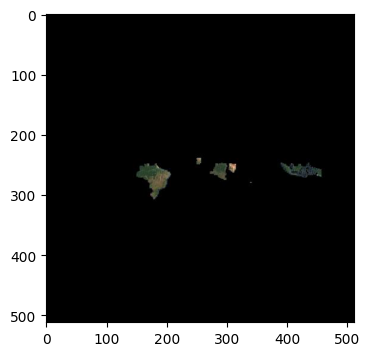

In [18]:
show_thumbnail(f"/vsigs_streaming/{BUCKET_NAME}/{DEST_PREFIX}/{OVERVIEW_FILENAME}")

## Next steps

To use the imagery generated above in Ground, you currently need to manually add the URL to each Ground survey in should be made available:

1. Open the Ground web console.
2. Select a Survey.
3. Click the gear icon in the top-right corner and click "Edit survey".
4. Click "JSON" in the left side menu.
5. Directly under the top-level "`{`", paste in the snippet generated by running the next cell.

In [ ]:
print('''
  "tileSources": [
    {
      "url": "https://storage.googleapis.com/''' + BUCKET_NAME + '/' + DEST_PREFIX + '''"
    }
  ],
''')